In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "figure.figsize": [12.0, 5.0],
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

## Pictures indicating Variational Inference

Variational inference attempts to fit a multivariate Gaussian to a posterior by minimizing the KL divergence. If your posterior is nearly Gaussian, this turns a very slow sampling procedure to a very fast optimization procedure! On the downside, it is *not* exact, and we mostly lack the theory to quantify how bad the approximate inference is!

Two "flavors" of variational inference use "mean field", or diagonal covariance, which is most common in ADVI implementations, and "full rank", which may blow out memory for large problems.

In [3]:
import theano
theano.config.compute_test_value = 'raise'  # funny bug when first making a theano variable

In [4]:
import pymc3 as pm
import theano.tensor as tt

def _get_bounds(samples):
    """Helper function to draw consistent bounds"""
    x_max, y_max = 0, 0
    for x_draws, y_draws in samples.values():
        x_max = max(x_max, np.abs(x_draws).max())
        y_max = max(y_max, np.abs(y_draws).max())
    top = max(x_max, y_max)
    return (-top, top)


def density_model(Ω):
    """This is the "modeling" step.  
    
    We are using PyMC3, and assuming we get an object Ω that represents some joint
    distribution. We require Ω to have two methods: `logp` and `random`. The logp should also
    be defined in a Theano-compatible fashion so it can compute the gradients.
    """
    with pm.Model() as model:
        omega = pm.DensityDist('Ω', Ω.logp, shape=2)
    return model

def sampler(Ω, N=1000):
    """This is the "inference" step
    
    Note that the only added difficulty in using ADVI is that we have a call to `pm.fit` in order to learn
    the parameters for the mean-field or full-rank approximation.
    """
    samples = {'Ground Truth': Ω.random(size=N).T}
    with density_model(Ω):
        samples['NUTS'] = pm.sample(N, step=pm.NUTS(), chains=1)['Ω'].T
        
        for method in ('advi', 'fullrank_advi'):
            inference = pm.fit(n=30000, method=method)
            samples[method] = inference.sample(N)['Ω'].T
            
    return samples


def plotter(samples):
    """Helper to plot the output of `sampler`.  A little flexible in case we want to add more VI methods.
    """
    size = int(np.ceil(len(samples) ** 0.5))
    fix, axs = plt.subplots(size, size, figsize=(12, 8))
    bounds = _get_bounds(samples)
    for (label, (x, y)), ax in zip(samples.items(), axs.ravel()):
        ax.plot(x, y, 'o', alpha = 0.5)
        ax.set_title(label)
        ax.axes.set_xlim(bounds)
        ax.axes.set_ylim(bounds)
        

def sample_and_plot(dist):
    """For the lazy"""
    samples = sampler(dist)
    plotter(samples)


### Ill conditioned Gaussian

In [5]:
mu = tt.zeros(2,)
cov = tt.as_tensor([[1e-2, 0.], [0., 1e2]])
Ω = pm.MvNormal.dist(mu=mu, cov=cov, shape=2, testval=mu)

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1152.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 0.09657: 100%|██████████| 30000/30000 [00:07<00:00, 3965.42it/s] 
Finished [100%]: Average Loss = 0.097131
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

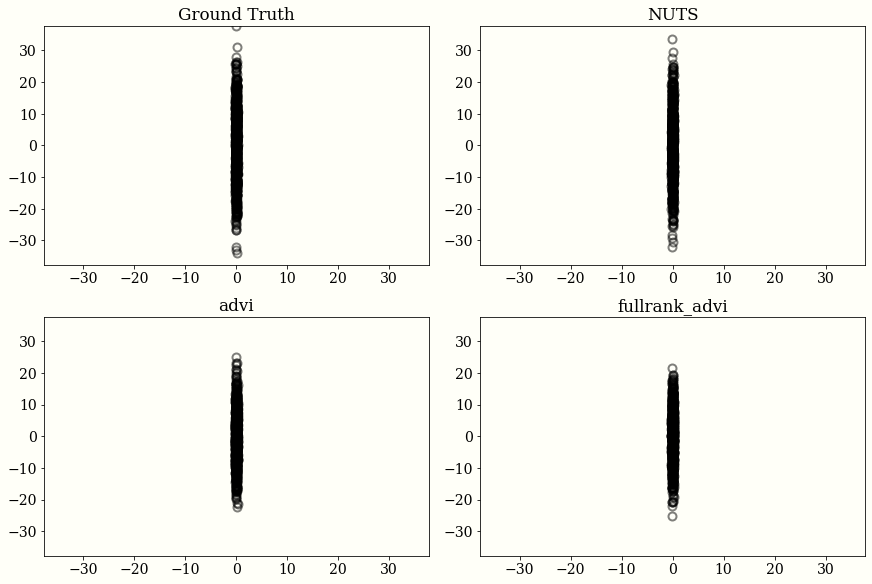

In [6]:
sample_and_plot(Ω)

### Strongly correlated Gaussian

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:05<00:00, 256.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 2.7394: 100%|██████████| 30000/30000 [00:10<00:00, 2874.82it/s]
Finished [100%]: Average Loss = 2.744
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

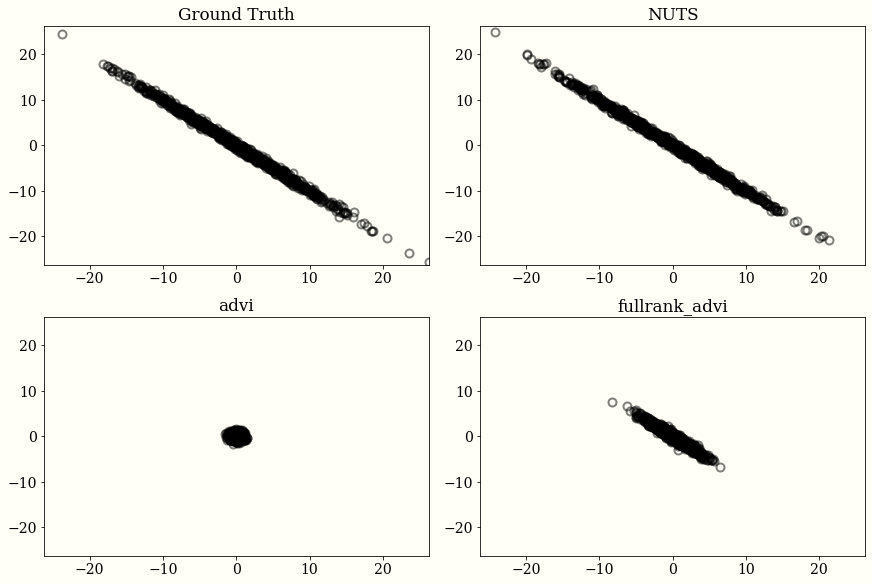

In [7]:
mu = tt.zeros(2,)
cov = tt.as_tensor([[50.05, -49.95], [-49.95, 50.05]])
Ω = pm.MvNormal.dist(mu=mu, cov=cov, shape=2, testval=mu)

sample_and_plot(Ω)

### Mixture of Gaussians

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:02<00:00, 739.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 5.969: 100%|██████████| 30000/30000 [00:11<00:00, 2574.35it/s] 
Finished [100%]: Average Loss = 5.9217
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

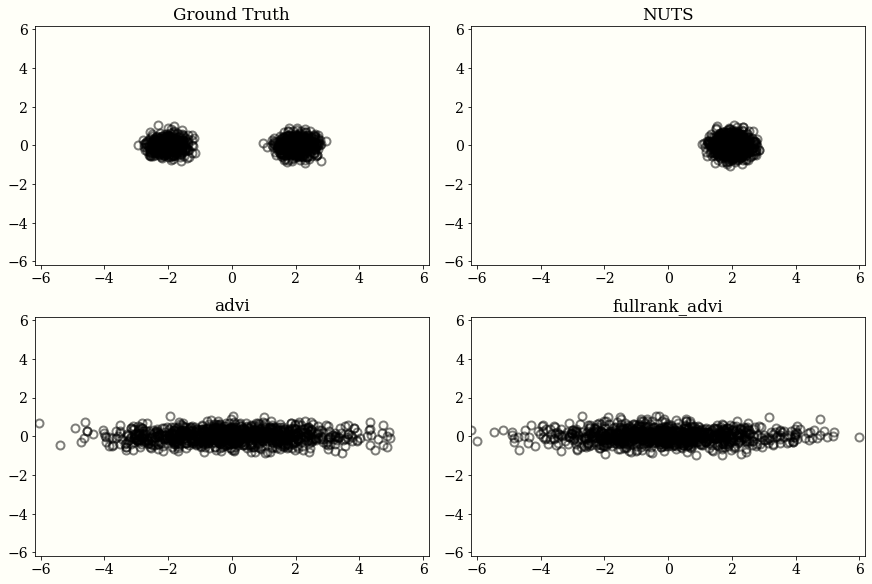

In [8]:
class MoG(object):
    def __init__(self, centers, sds):
        covs = [tt.as_tensor([[sd, 0], [0, sd]]) for sd in sds]

        self.rvs = [pm.MvNormal.dist(mu=center, cov=cov, shape=2) for center, cov in zip(centers, covs)]
        
    def random(self, size=1):
        return np.array([rv.random() for rv in np.random.choice(self.rvs, size=size)])
    
    def logp(self, value):
        return pm.math.logsumexp([rv.logp(value) for rv in self.rvs]) - np.log(len(self.rvs))

sample_and_plot(MoG(centers=[np.array([-2, 0]), np.array([2, 0])], sds=[0.1, 0.1]))

### Mixture of Gaussians with different scale

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 990.86it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 0.70752: 100%|██████████| 30000/30000 [00:16<00:00, 1807.31it/s]
Finished [100%]: Average Loss = 0.70748
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inst

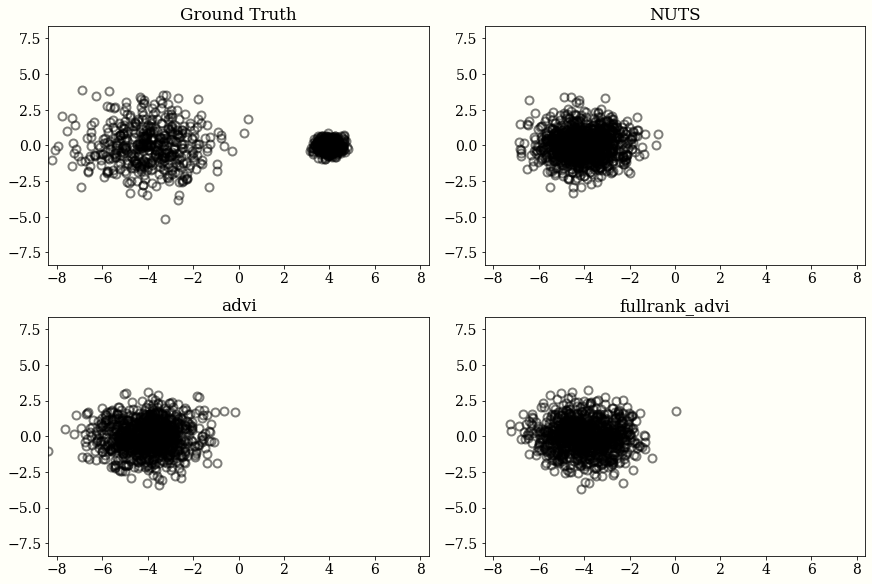

In [9]:
sample_and_plot(MoG(centers=[np.array([-4, 0]), np.array([4, 0])], sds=[2, 0.1]))

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 898.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 12.136: 100%|██████████| 30000/30000 [00:16<00:00, 1866.60it/s]
Finished [100%]: Average Loss = 12.218
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

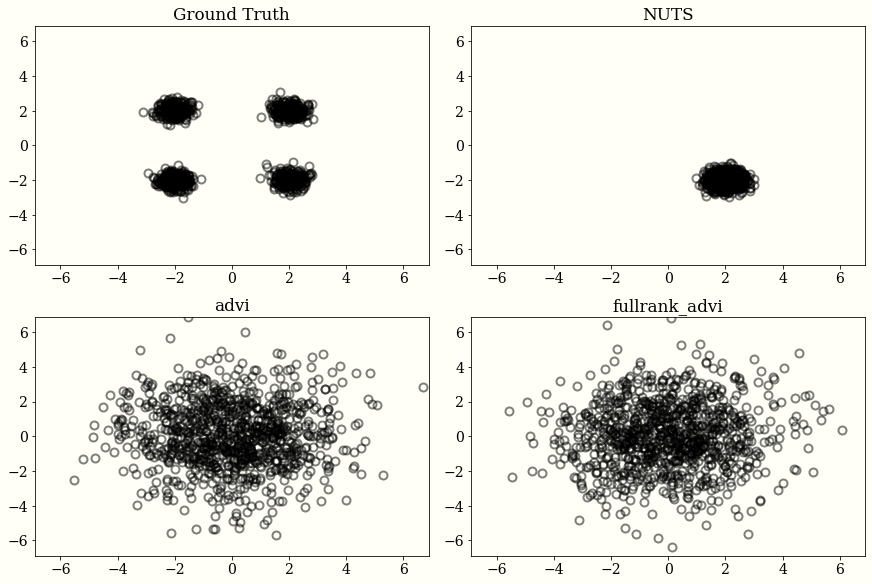

In [10]:
sample_and_plot(MoG(centers=[np.array([-2, -2]), np.array([2, -2]), np.array([-2, 2]), np.array([2, 2])], sds=[0.1, 0.1, 0.1, 0.1]))

### Mixture of non axis-aligned Gaussians

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 944.10it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks
Average Loss = 8.8355: 100%|██████████| 30000/30000 [00:12<00:00, 2382.21it/s]
Finished [100%]: Average Loss = 8.8206
  0%|          | 0/30000 [00:00<?, ?it/s]/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instea

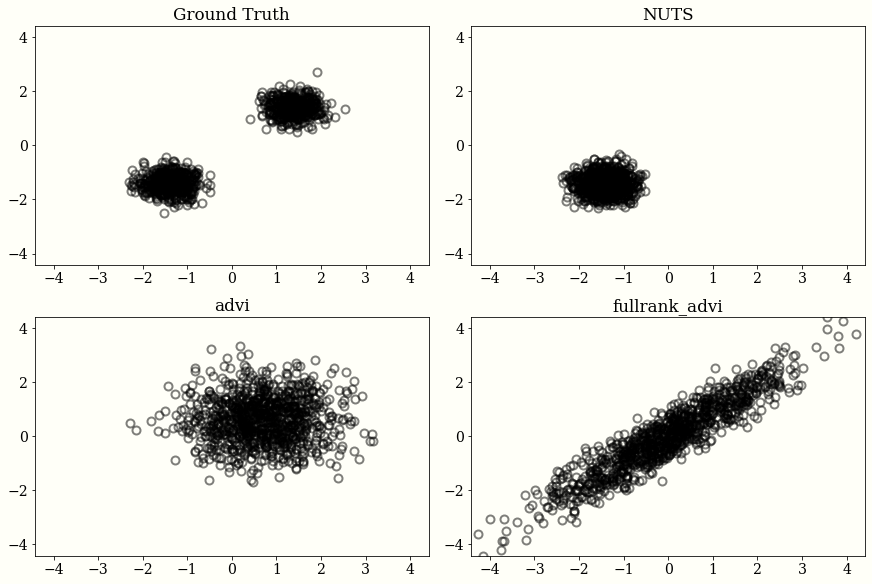

In [11]:
θ = np.pi / 4
rot_45 = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
Ω = MoG(centers=[rot_45.dot(np.array([-2, 0])), rot_45.dot(np.array([2, 0]))], sds=[0.1, 0.1])

sample_and_plot(Ω)

# Getting 1,000 samples of a linear regression model in different Probabilistic Programming Languages

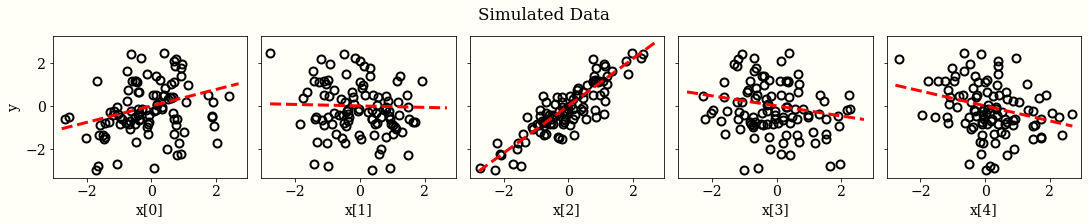

In [12]:
# Trailing underscore means the model has no access to the variable
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



## PyMC3

- Uses `theano`
- Sampler is NUTS
- Does advanced tuning

```bash
pip install pymc3
```

https://docs.pymc.io/

In [13]:
%%time
import pymc3 as pm
import theano.tensor as tt

with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3519.58draws/s]


CPU times: user 2.17 s, sys: 200 ms, total: 2.37 s
Wall time: 3.08 s


## PyStan

- Uses `Stan`, a stand-alone progamming language specialized to probabilistic programs
- Self-rolled auto-differentiation
- Sampler is NUTS
- Does advanced tuning

```bash
pip install pystan
```


https://pystan.readthedocs.io

In [14]:
%%time
import pystan

linear_regression = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] w;       // coefficients for predictors
}
model {
  y ~ normal(X * w, 0.1);  // likelihood
}
"""

linear_data = {'N': ndata,
               'K': ndims,
               'y': y_obs,
               'X': X
              }

sm = pystan.StanModel(model_code=linear_regression)
fit = sm.sampling(data=linear_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b8e41c9d58148edcdc9d099a42ee4b NOW.


CPU times: user 1.45 s, sys: 136 ms, total: 1.58 s
Wall time: 44.6 s


In [15]:
pystan.__version__

'2.19.1.1'

## emcee

- Affine invariant ensemble MCMC sampler
- No gradients - limited scaling with dimension
- Well tested, easy to install

```bash
pip install emcee
```

https://emcee.readthedocs.io

In [16]:
%%time
import scipy.stats as st

import emcee

# log likelihood
def lnlike(w, X, y):
    model = X.dot(w) 
    inv_sigma2 = 0.1 ** -2
    return -0.5*(np.sum((y-model)**2)*inv_sigma2 - np.log(inv_sigma2))

# Define a prior for w
w_rv = st.multivariate_normal(np.zeros(ndims), np.eye(ndims))

# Log probability for w
lnprior = w_rv.logpdf

# logp(w | X, y) = logp(y | X, w) + logp(w)
def lnprob(w, X, y):
    return lnprior(w) + lnlike(w, X, y)

nwalkers = 100
pos = w_rv.rvs(size=nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, args=(X, y_obs))

pos, lprob, rstate  = sampler.run_mcmc(pos, 1000)

CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.12 s


In [17]:
emcee.__version__

'3.0.2'

## Tensorflow Probability

- "scipy-stats, with gradients"
- Also has MCMC algorithms, keras layers with uncertainty
- Built on tensorflow, well integrated into ecosystem
- Has NUTS, HMC, _some_ tuning
- Massively parallel

```bash
pip install tensorflow-probability
```
https://www.tensorflow.org/probability

In [18]:
%%time
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=0.1, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return w_prob + y_prob


# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function target_log_prob_fn at 0x7f7b0c15b4d0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function target_log_prob_fn at 0x7f7b0c15b4d0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
CPU times: user 15.2 s, sys: 512 ms, total: 15.7 s
Wall time: 14.2 s


In [19]:
tfp.__version__

'0.9.0-dev20200110'

## Pyro

- Built on pytorch
- Has HMC, NUTS, not sure on tuning
- Used to be focused on variational inference, has done more MCMC

```bash
pip install pyro-ppl 
```

https://pyro.ai/

In [20]:
# %%time
# import pyro
# import torch
# from pyro.infer.mcmc import NUTS, MCMC
# import pyro.distributions as dist


# def model(X):
#     w = pyro.sample('w', dist.Normal(torch.zeros(ndims), torch.ones(ndims)))
#     y = pyro.sample('y', dist.Normal(torch.matmul(X, w), 0.1 * torch.ones(ndata)), obs=torch.as_tensor(y_obs, dtype=torch.float32))
#     return y

# nuts_kernel = NUTS(model, adapt_step_size=True)
# py_mcmc = MCMC(nuts_kernel, num_samples=1_000, warmup_steps=500)

# py_mcmc = py_mcmc.run(torch.as_tensor(X, dtype=torch.float32))

In [22]:
# pyro.__version__

## Numpyro

- Built on `jax`
- Same team as pyro
- Has NUTS, HMC
- Small and quick

```bash
pip install git+https://github.com/pyro-ppl/numpyro.git
```

In [ ]:
# %%time
# import jax.numpy as jnp
# from jax import random

# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer import MCMC, NUTS


# def model(X=None):
#     w = numpyro.sample('w', dist.Normal(jnp.zeros(ndims), jnp.ones(ndims)))
#     y = numpyro.sample('y', dist.Normal(jnp.dot(X, w), 0.1 * jnp.ones(ndata)), obs=jnp.array(y_obs))
#     return y

# rng_ = random.PRNGKey(0)

# kernel = NUTS(model)
# mcmc = MCMC(kernel, 500, 1000)
# mcmc.run(rng_, X=X)

In [23]:
# numpyro.__version__

## Brancher

- Doesn't actually implement MCMC, I think. Does variational inference.
- Beautiful!
- Built on pytorch

```python
pip install brancher
```

https://brancher.org/

In [ ]:
# %%time
# from brancher.variables import ProbabilisticModel
# from brancher.standard_variables import NormalVariable
# from brancher import inference
# import brancher.functions as BF

# import torch

# # Model
# w = NormalVariable(loc=torch.zeros(ndims), scale=1., name="w")
# y = NormalVariable(loc=BF.matmul(torch.as_tensor(X, dtype=torch.float32), w), scale=0.1, name="y")

# y.observe(y_obs)
# model = ProbabilisticModel([w, y])

## Edward 2

- Built on tensorflow and tensorflow probability
- Mostly a model building language!
- Installed with tensorflow probability, for 2 more months
- Inference is with tensorflow probability

```bash
pip install git+https://github.com/google/edward2.git
```

In [ ]:
# %%time
# import edward2 as ed
# import tensorflow as tf

# X_tensor = tf.convert_to_tensor(X, dtype='float32')

# def linear_regression(X):
#     """Bayesian logistic regression p(y | x) = int p(y | x, w, b) p(w, b) dwdb."""
#     w = ed.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
#     y = ed.Normal(loc=tf.matmul(X, w), scale=0.1, name='y')
#     return y

# log_joint = ed.make_log_joint_fn(linear_regression)


# def target_log_prob_fn(w):
#     """Target log-probability as a function of states."""
#     return log_joint(X_tensor,
#                      w=w,
#                      y=y_obs.reshape(-1, 1))

# # Initialize the HMC transition kernel.
# num_results = 1000
# num_burnin_steps = 500

# adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#     tfp.mcmc.HamiltonianMonteCarlo(
#         target_log_prob_fn=target_log_prob_fn,
#         num_leapfrog_steps=4,
#         step_size=0.01),
#     num_adaptation_steps=int(num_burnin_steps * 0.8))

# ed_samples, is_accepted = tfp.mcmc.sample_chain(
#     num_results=num_results,
#     num_burnin_steps=num_burnin_steps,
#     current_state=tf.zeros((ndims, 1)),
#     kernel=adaptive_hmc,
#     trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

## PyMC4
- Built on tensorflow and tensorflow probability
- Very alpha
- Mostly a modelling layer still
- Uses HMC, and the tuning is still not very good!

```bash
pip install git+https://github.com/pymc-devs/pymc4.git
```

In [25]:
y

y

In [39]:
%%time
import pymc4

@pymc4.model()
def linear_model():
    w = yield pymc4.distributions.Normal('w', loc=0., scale=1., plate=(5, 1))
    yield pymc4.distributions.Normal('y', loc=X @ w, scale=0.1, observed=y_obs.reshape((100, 1)))
    
trace = pymc4.inference.sampling.sample(linear_model())

CPU times: user 13.7 s, sys: 1.03 s, total: 14.7 s
Wall time: 6.9 s


In [40]:
pymc4.__version__

'4.0a1'

In [44]:
data = pymc4.trace_to_arviz(*trace)

In [48]:
data.posterior['linear_model/w'].mean(dim=['chain', 'draw'])

<xarray.DataArray 'linear_model/w' (linear_model/w_dim_0: 5, linear_model/w_dim_1: 1)>
array([[ 0.37239093],
       [-0.03539175],
       [ 1.0943285 ],
       [-0.2342457 ],
       [-0.3391409 ]], dtype=float32)
Coordinates:
  * linear_model/w_dim_0  (linear_model/w_dim_0) int64 0 1 2 3 4
  * linear_model/w_dim_1  (linear_model/w_dim_1) int64 0

In [49]:
w_

array([ 0.38273243, -0.03424228,  1.09634685, -0.2342158 , -0.34745065])